In [15]:
import os
from datetime import datetime,timezone,timedelta
from csv import reader

import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle

import matplotlib.pyplot as plt

from scipy import signal

import data_filter as dafi
import data_process as dapr
import lib_plot

In [22]:
main_path = os.path.abspath('../data/20221031/2/')


azimut_mask = [270,330]
elevation_mask = [0,50]
min_height = 2
max_height = 6
frequency = dapr.generate_frequency(min_height=min_height,max_height=max_height)
starttime = datetime(year=2022,month=10,day=31,hour=8,minute=0,second=0,tzinfo=timezone.utc)
endtime = datetime(year=2022,month=10,day=31,hour=14,minute=0,second=0,tzinfo=timezone.utc)
deltatime = timedelta(minutes=10)

data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,elevation_mask=elevation_mask,sn1_trigger=True)


split_data_dict = dafi.split_data(data_dict,starttime,endtime,deltatime)

In [23]:
# 太短也删了吧
result_dict,debug_ele,debug_snr = dapr.data_prepare(split_data_dict,frequency=frequency)

: 

: 

In [18]:
result_dict = dapr.extract_height_as_max_peak(result_dict,frequency=frequency)

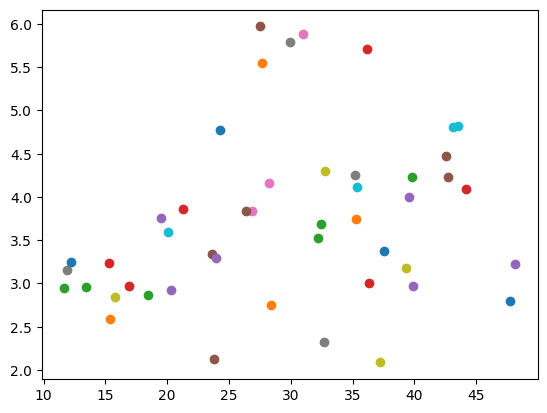

In [19]:
for satellite_code in result_dict:
    for i,height in enumerate(result_dict[satellite_code]['maximal_height']):
        plt.scatter(result_dict[satellite_code]['elevation'][i]['avg'],height)

In [20]:
result_dict[satellite_code]['elevation']

[{'avg': 23.470235849056603, 'min': 22.843, 'max': 24.073},
 {'avg': 24.42274111675127, 'min': 24.076, 'max': 24.759}]

In [21]:

'''
try:
    para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                design_matrix.T),snr_sort)
except:
    height = []
    frequency = float("nan")
    power = float("nan")
else:
    snr_ref = snr_sort - (elevation_sort**2 * para[0,0] + \
                para[1,0]*elevation_sort + para[2,0])

    # lsp analysis
    x_data = (np.sin(elevation_sort.T*np.pi/180) * 4 * np.pi / wavelength).ravel()
    y_data = snr_ref.ravel()
    frequency = np.arange(min_height,max_height,0.001)

    power = signal.lombscargle(x_data,y_data,frequency,normalize=True)
    plt.plot(frequency,power)
    peaks,_= signal.find_peaks(power)
    if peaks.size != 0:
        peaks_power = power[peaks]

        height_peak = frequency[peaks]
        height = height_peak[peaks_power==max(peaks_power)]
    else:
        height = []
'''

'\ntry:\n    para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),                design_matrix.T),snr_sort)\nexcept:\n    height = []\n    frequency = float("nan")\n    power = float("nan")\nelse:\n    snr_ref = snr_sort - (elevation_sort**2 * para[0,0] +                 para[1,0]*elevation_sort + para[2,0])\n\n    # lsp analysis\n    x_data = (np.sin(elevation_sort.T*np.pi/180) * 4 * np.pi / wavelength).ravel()\n    y_data = snr_ref.ravel()\n    frequency = np.arange(min_height,max_height,0.001)\n\n    power = signal.lombscargle(x_data,y_data,frequency,normalize=True)\n    plt.plot(frequency,power)\n    peaks,_= signal.find_peaks(power)\n    if peaks.size != 0:\n        peaks_power = power[peaks]\n\n        height_peak = frequency[peaks]\n        height = height_peak[peaks_power==max(peaks_power)]\n    else:\n        height = []\n'